In [40]:
from pprint import pprint
import seaborn as sns
import numpy as np
from sqlalchemy import PickleType
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
import pickle
import logging
import ruamel.yaml as yaml
from copy import deepcopy
import torch

from utils.data_storage.dataframe2sql import read_pkl_sql
from utils.config.loaders import get_sql_types
from zunis.utils.config.loaders import get_default_integrator_config
from zunis.integration import Integrator
sns.set_theme()
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
from itertools import product

d = 2

In [41]:
get_default_integrator_config()

Configuration({'flow': 'pwquad', 'flow_options': NestedMapping({'cell_params': NestedMapping({'d_hidden': 256, 'n_bins': 10, 'n_hidden': 8}), 'masking': 'iflow', 'masking_options': NestedMapping({'repetitions': 2})}), 'loss': 'variance', 'n_points_survey': 10000, 'n_iter': 10, 'trainer_options': NestedMapping({'minibatch_size': 1.0, 'max_reloads': 0, 'n_epochs': 50, 'optim': NestedMapping({'optim_cls': 'Adam', 'optim_config': NestedMapping({'betas': (0.9, 0.999), 'eps': 1e-08, 'lr': 0.001})}), 'checkpoint': True, 'checkpoint_on_cuda': True, 'checkpoint_path': None})})

In [42]:
from utils.benchmark.vegas_benchmarks import VegasRandomHPBenchmarker
from utils.config.loaders import get_sql_types
from zunis.utils.config.configuration import Configuration

from utils.integrands.pretty import CircleLineIntegrand, SineIntegrand, SineLineIntegrand
from utils.integrands.gaussian import DiagonalGaussianIntegrand, CamelIntegrand
from utils.integrands.volume import HyperrectangleVolumeIntegrand, HypersphereVolumeIntegrand

In [43]:
dtypes = get_sql_types()

In [44]:
def get_loss_history(result):
    return sum(result.loc[0,"value_history"]["training record"].apply(lambda x: x["metrics"]["loss"]),[])

# Camel integrand

In [45]:
d=2
s = 0.3
norm = 1

In [163]:
def camel_pretty_plot(config):
    
    benchmarker = VegasRandomHPBenchmarker(n=1)
    config = benchmarker.set_benchmark_grid_config(config=config, cuda=0)
    return benchmarker.run(integrand=CamelIntegrand, **config)
    


In [164]:
base_config = Configuration({
    "dimensions": d,
    "base_integrand_params": {
        "s": 0.3,
        "norm": 1
    },
    "base_integrator_config": {
        "checkpoint_on_cuda": False,
#         "n_bins": 30,
#         "checkpoint_path": None,
#         "n_epochs": 20,
#         "lr": 1.e-3,
#         "flow": "pwquad"
    },
    "debug":False,
    "experiment_name": "camel_pretty_plot",
    "keep_history": True
}, check=False)



In [165]:
camel_results = {'variance_ratio':[], 'flat_variance_ratio': []}
config = deepcopy(base_config)
# config["n_epochs"] = 15
# config["n_bins"] = 10
# config["lr"] = 1e-3
for i in range(20):
    result, _ = camel_pretty_plot(config)
    print(result["variance_ratio"])
    camel_results['variance_ratio'].append(result['variance_ratio'])
    camel_results['flat_variance_ratio'].append(result['flat_variance_ratio'])


Logging into ./camel_pretty_plot:5326b68.log
0    57.036841
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:6318936.log
0    117.115614
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:d5a743c.log
0    107.101897
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:75d1df6.log
0    71.115172
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:2b2b800.log
0    99.129343
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:a058f4d.log
0    87.708488
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:b7f60c2.log
0    140.49343
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:88e4cba.log
0    180.82685
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:1409dcf.log
0    142.473519
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:6f368a7.log
0    82.301176
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty

In [166]:
print(np.mean(camel_results['flat_variance_ratio']))
print(np.std(camel_results['flat_variance_ratio']))

print(np.mean(camel_results['variance_ratio']))
print(np.std(camel_results['variance_ratio']))

656.7703179749324
211.53056889206263
110.36185958397864
35.24422496463223


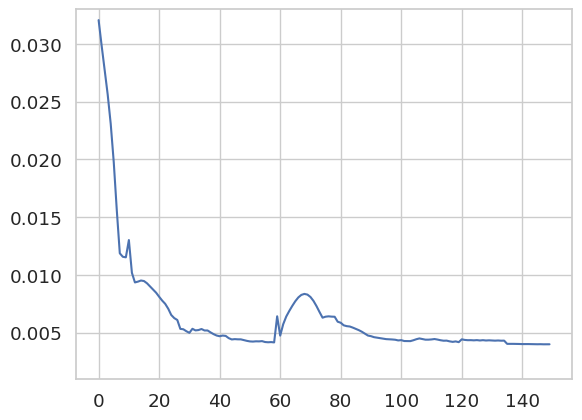

In [19]:
fig, ax = plt.subplots()
ax.plot(get_loss_history(result))
ax.set(ylim=[1.e-3,3.3e-2])
plt.show()

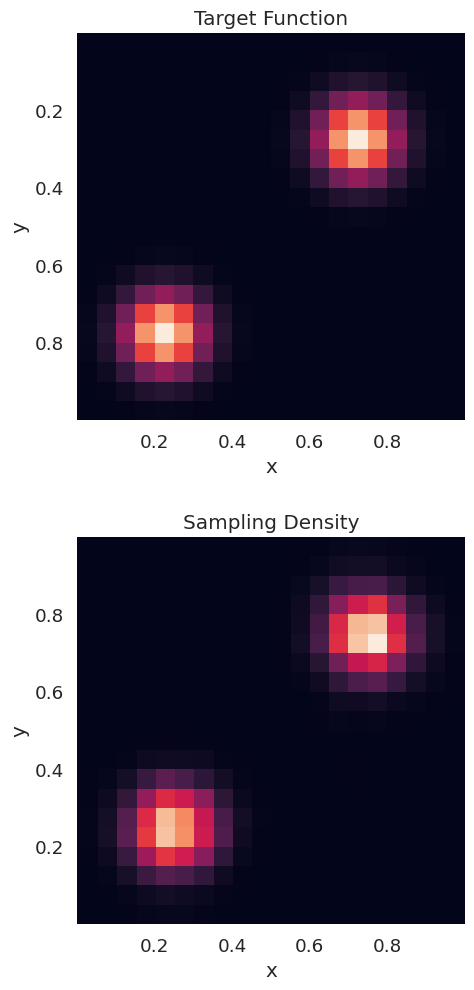

In [20]:
x, _, _ = integrator.sample_refine()
x = x.cpu().numpy()
fig, ax = plt.subplots(2,1)
fig.set_size_inches(5,12)

n = 20
f = CamelIntegrand(d=d, s=s, norm=norm)
fmatrix = np.zeros((n,n))
blackmatrix = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        fmatrix[i,n-1-j] = f(torch.tensor([[i/n,j/n]])).numpy()

ticks = np.array([0.2, 0.4, 0.6, 0.8])
hm_xticks = [""]*n
hm_yticks = [""]*n        
for t in ticks:
    hm_xticks[int(t*n)] = t
    hm_yticks[-int(t*n)] = t

sns.heatmap(fmatrix,ax=ax[0],cbar=False, xticklabels=False, yticklabels=False, cmap="rocket")
ax[0].set(xlabel="x", ylabel="y", title="Target Function", aspect=1)
ax[0].set_xticks(n*ticks)
ax[0].set_xticklabels(ticks)
ax[0].set_yticks(n*ticks)
ax[0].set_yticklabels(ticks)    

sns.heatmap(blackmatrix,ax=ax[1],cbar=False, cmap="rocket")
sns.histplot(x=x[:,0], y=x[:,1], ax=ax[1], cmap="rocket", fill=True, bins=n)
plt.xticks(rotation=0)
ax[1].set(xlabel="x", ylabel="y", title="Sampling Density", aspect=1, xlim=[0,1], ylim=[0,1])
ax[1].set_xticks(ticks)
ax[1].set_xticklabels(ticks, rotation=0)
ax[1].set_yticks(ticks)
ax[1].set_yticklabels(ticks, rotation=0)



plt.show()

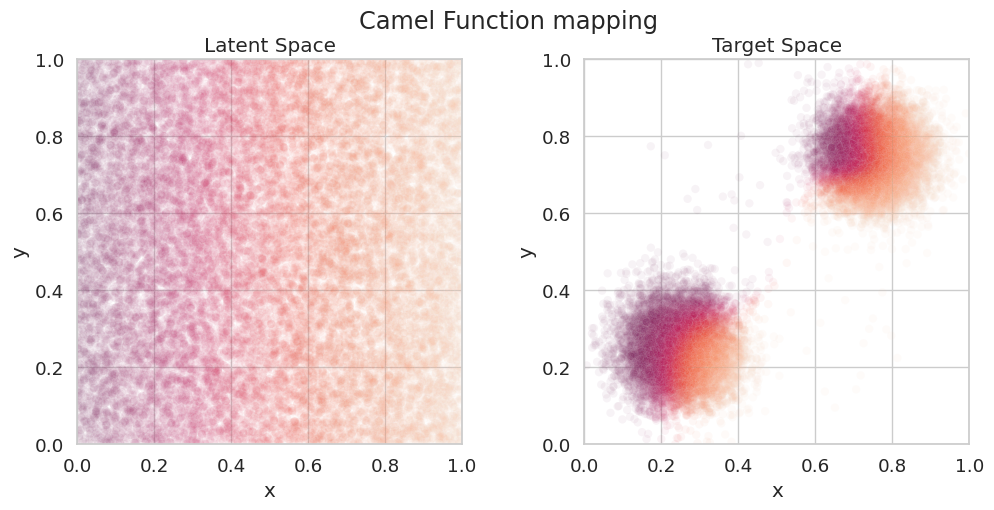

In [23]:
x, _, _ = integrator.sample_survey(n_points=20000)
x = x.cpu()
fig, axs = plt.subplots(1,2)
sns.scatterplot(x=x[:,0], y=x[:,1], hue=x[:,0], legend=False, palette="rocket", hue_norm=(-.5,1.2),alpha=0.05, ax=axs[0])

x = x.to("cuda")
x = torch.cat((x, torch.ones(len(x), device="cuda").unsqueeze(-1)), dim=-1)
y = integrator.model_trainer.flow(x)[:,:2].detach().cpu()
x = x.cpu()

sns.scatterplot(x=y[:,0], y=y[:,1], hue=x[:,0],legend=False, palette="rocket", hue_norm=(-.5,1.2),alpha=0.05, ax=axs[1])
axs[0].set(aspect=1, xlabel="x", ylabel="y", title="Latent Space", xlim=[0,1], ylim=[0,1])
axs[1].set(aspect=1, xlabel="x", ylabel="y", title="Target Space", xlim=[0,1], ylim=[0,1])
fig.set(size_inches=(12,5))
fig.suptitle("Camel Function mapping")
plt.show()

In [33]:
colors = ["#751a35", "#b34233", "#d28f33", "#d4b95e", "#4ea2a2"]
colors_husl = [(0, 78, 60),
               (16, 73, 60),
               (46, 88, 60),
               (69, 75, 60),
               (192, 75, 61)]
divpal = [
    sns.diverging_palette(c[0], c[0]+30, s=c[1], l=c[2], as_cmap=True, center="dark", sep=1) for c in colors_husl
]

named_palettes = ["rocket_r", "crest", "viridis", "flare", "magma"]
alternating = ["flare", "flare_r", "flare", "flare_r", 'flare']

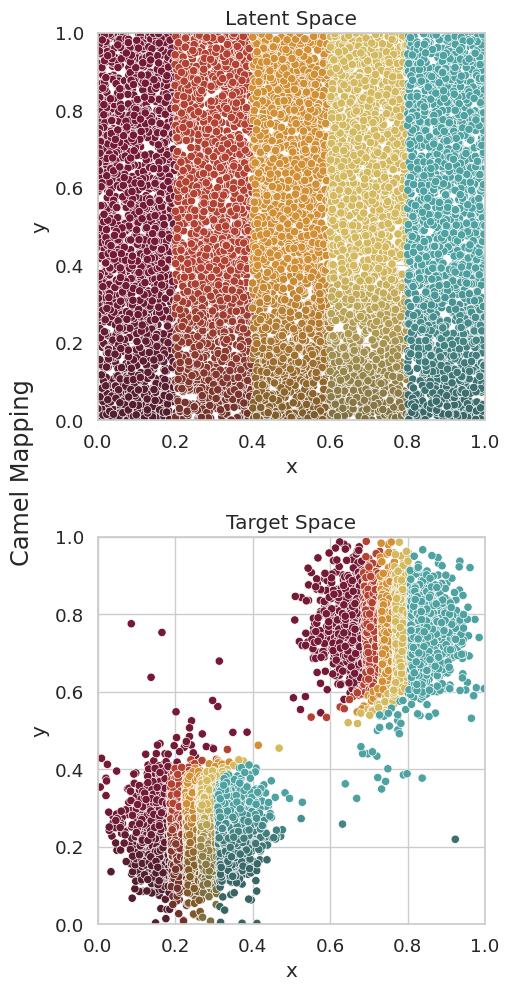

In [21]:
fig, axs = plt.subplots(2,1)
fig.set_size_inches(5,12)
colors = ["#751a35", "#b34233", "#d28f33", "#d4b95e", "#4ea2a2"]
for i in range(5):
    low = i*0.2
    high = low+0.2
    
    x, _, _ = integrator.sample_survey()
    x = x.cpu()
    x=x[((low<x[:, 0]) &  (x[:,0] < high))]

    sns.scatterplot(x=x[:,0], y=x[:,1], hue=x[:,1], legend=False, palette=sns.dark_palette(colors[i], as_cmap=True), hue_norm=(-.4,.4), ax=axs[0])



    x = x.to("cuda")
    x = torch.cat((x, torch.ones(len(x), device="cuda").unsqueeze(-1)), dim=-1)
    y = integrator.model_trainer.flow(x)[:,:2].detach().cpu()
    x = x.cpu()

    sns.scatterplot(x=y[:,0], y=y[:,1], hue=x[:,1], legend=False, palette=sns.dark_palette(colors[i], as_cmap=True), hue_norm=(-.4,.4),ax=axs[1])

axs[0].set(aspect=1, xlabel="x", ylabel="y", title="Latent Space", xlim=[0,1], ylim=[0,1])
axs[1].set(aspect=1, xlabel="x", ylabel="y", title="Target Space", xlim=[0,1], ylim=[0,1])
fig.set(size_inches=(5,12))
fig.supylabel("Camel Mapping", x=-.05)
plt.show()

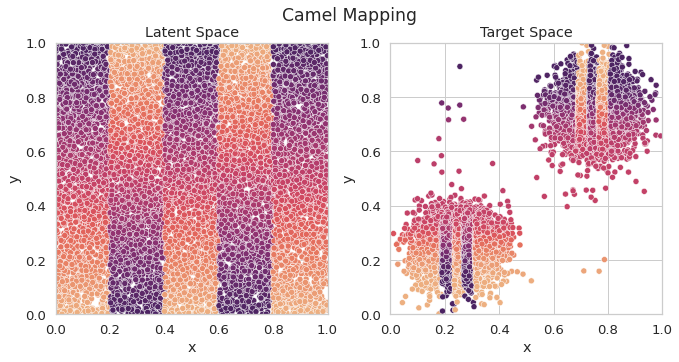

In [330]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(12,5)
colors = ["#751a35", "#b34233", "#d28f33", "#d4b95e", "#4ea2a2"]
for i in range(5):
    low = i*0.2
    high = low+0.2
    
    x, _, _ = integrator.sample_survey()
    x = x.cpu()
    x=x[((low<x[:, 0]) &  (x[:,0] < high))]

    sns.scatterplot(x=x[:,0], y=x[:,1], hue=x[:,1], legend=False, palette=alternating[i], ax=axs[0])



    x = x.to("cuda")
    x = torch.cat((x, torch.ones(len(x), device="cuda").unsqueeze(-1)), dim=-1)
    y = integrator.model_trainer.flow(x)[:,:2].detach().cpu()
    x = x.cpu()

    sns.scatterplot(x=y[:,0], y=y[:,1], hue=x[:,1], legend=False, palette=alternating[i],ax=axs[1])

axs[0].set(aspect=1, xlabel="x", ylabel="y", title="Latent Space", xlim=[0,1], ylim=[0,1])
axs[1].set(aspect=1, xlabel="x", ylabel="y", title="Target Space", xlim=[0,1], ylim=[0,1])
fig.set(size_inches=(11,5))
fig.suptitle("Camel Mapping")
plt.show()

# CircleLine integrand

In [109]:
d = 2
s = 0.3
norm = 1

In [110]:
def cl_pretty_plot(config):
    
    benchmarker = VegasRandomHPBenchmarker(n=1)
    config = benchmarker.set_benchmark_grid_config(config=config, cuda=0)
    return benchmarker.run(integrand=CircleLineIntegrand, **config)
    


In [111]:
base_config = Configuration({
    "dimensions": d,
    "base_integrand_params": {
        "r":0.3,
        "sig":0.05
    },
    "base_integrator_config": {
        "checkpoint_on_cuda": False,
#         "n_bins": 50,
#         "checkpoint_path": "pretty_caml.chkpt",
#         "n_epochs": 20,
#         "lr": 1.e-3
    },
    "debug":False,
    "experiment_name": "camel_pretty_plot",
    "keep_history": True
}, check=False)



In [112]:
config = deepcopy(base_config)
cl_results = {'variance_ratio':[], 'flat_variance_ratio': []}
config = deepcopy(base_config)
# config["n_epochs"] = 15
# config["n_bins"] = 10
# config["lr"] = 1e-3
for i in range(20):
    result, _ = cl_pretty_plot(config)
    print(result["variance_ratio"])
    cl_results['variance_ratio'].append(result['variance_ratio'])
    cl_results['flat_variance_ratio'].append(result['flat_variance_ratio'])

Logging into ./camel_pretty_plot:c5f66d3.log
0    215.194476
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:eae6aeb.log
0    76.250088
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:daa94b4.log
0    83.137756
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:a42daf7.log
0    143.412361
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:294db16.log
0    98.901904
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:46dbfd0.log
0    134.483347
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:8b5fbe0.log
0    110.252521
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:e37e13f.log
0    104.097171
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:4f706f3.log
0    168.545172
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:42c9e29.log
0    97.910491
Name: variance_ratio, dtype: float64
Logging into ./camel_pre

In [113]:
print(np.mean(cl_results['flat_variance_ratio']))
print(np.std(cl_results['flat_variance_ratio']))

print(np.mean(cl_results['variance_ratio']))
print(np.std(cl_results['variance_ratio']))

69.13762376172517
20.924440767845834
136.93878976919717
59.97790901510379


In [ ]:
fig, ax = plt.subplots()
ax.plot(get_loss_history(result))

plt.show()

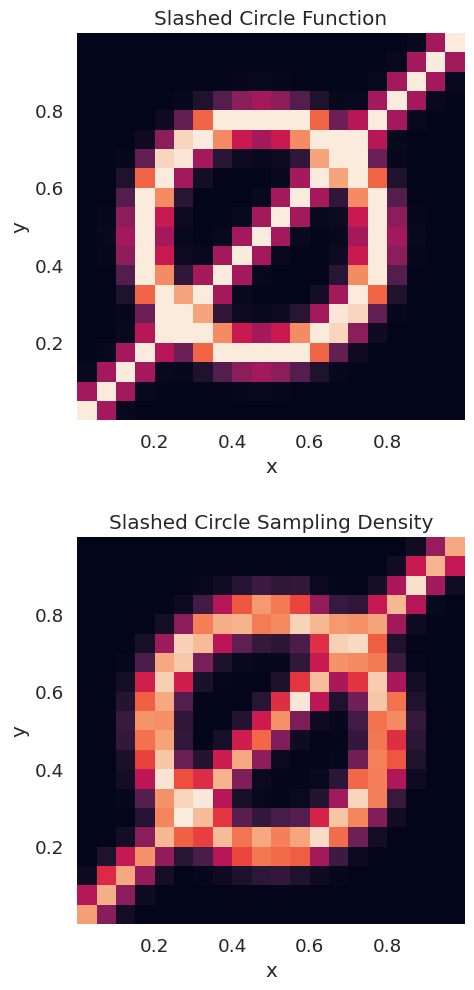

In [27]:
x, _, _ = integrator.sample_refine()
x = x.cpu().numpy()
fig, ax = plt.subplots(2,1)
fig.set_size_inches(5,12)

n = 20
f = CircleLineIntegrand(d=d, r=0.3, sig=0.05)
fmatrix = np.zeros((n,n))
blackmatrix = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        fmatrix[i,n-1-j] = f(torch.tensor([[i/n,j/n]])).numpy()

ticks = np.array([0.2, 0.4, 0.6, 0.8])
hm_xticks = [""]*n
hm_yticks = [""]*n        

sns.heatmap(fmatrix,ax=ax[0],cbar=False, xticklabels=False, yticklabels=False, cmap="rocket")
ax[0].set(xlabel="x", ylabel="y", title="Slashed Circle Function", aspect=1)
ax[0].set_xticks(n*ticks)
ax[0].set_xticklabels(ticks)
ax[0].set_yticks(n*ticks)
ax[0].set_yticklabels(reversed(list(ticks)))    

sns.heatmap(blackmatrix,ax=ax[1],cbar=False, cmap="rocket")
sns.histplot(x=x[:,0], y=x[:,1], ax=ax[1], cmap="rocket", fill=True, bins=n)
plt.xticks(rotation=0)
ax[1].set(xlabel="x", ylabel="y", title="Slashed Circle Sampling Density", aspect=1, xlim=[0,1], ylim=[0,1])
ax[1].set_xticks(ticks)
ax[1].set_xticklabels(ticks, rotation=0)
ax[1].set_yticks(ticks)
ax[1].set_yticklabels(ticks, rotation=0)

plt.show()

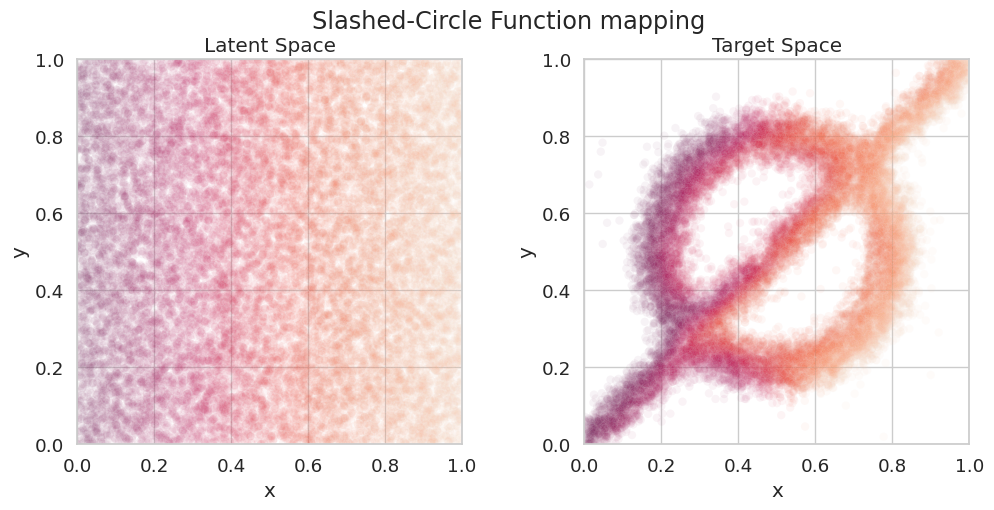

In [40]:
x, _, _ = integrator.sample_survey(n_points=20000)
x = x.cpu()
fig, axs = plt.subplots(1,2)
sns.scatterplot(x=x[:,0], y=x[:,1], hue=x[:,0], legend=False, palette="rocket", hue_norm=(-.5,1.2),alpha=0.05, ax=axs[0])

x = x.to("cuda")
x = torch.cat((x, torch.ones(len(x), device="cuda").unsqueeze(-1)), dim=-1)
y = integrator.model_trainer.flow(x)[:,:2].detach().cpu()
x = x.cpu()

sns.scatterplot(x=y[:,0], y=y[:,1], hue=x[:,0],legend=False, palette="rocket", hue_norm=(-.5,1.2),alpha=0.05, ax=axs[1])
axs[0].set(aspect=1, xlabel="x", ylabel="y", title="Latent Space", xlim=[0,1], ylim=[0,1])
axs[1].set(aspect=1, xlabel="x", ylabel="y", title="Target Space", xlim=[0,1], ylim=[0,1])
fig.set(size_inches=(12,5))
fig.suptitle("Slashed-Circle Function mapping")
plt.show()

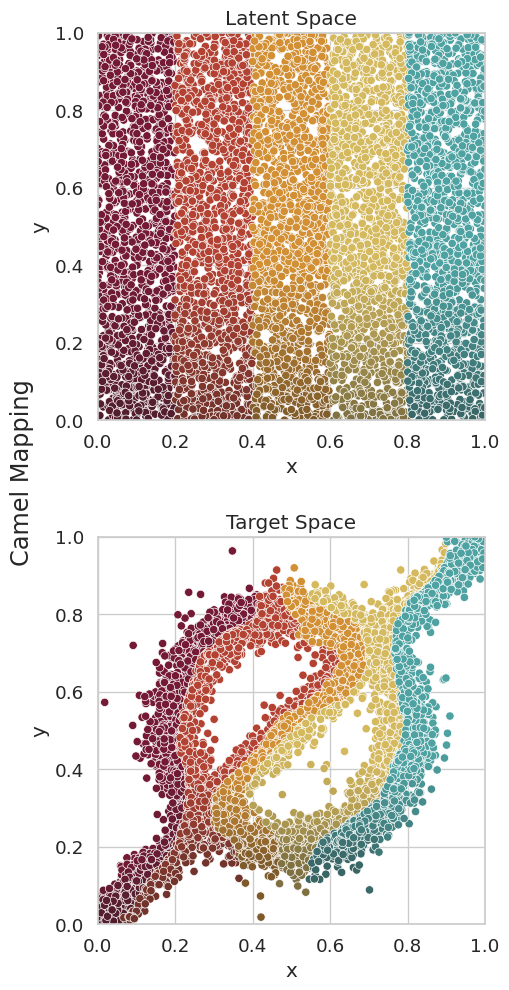

In [31]:
fig, axs = plt.subplots(2,1)
fig.set_size_inches(5,12)
colors = ["#751a35", "#b34233", "#d28f33", "#d4b95e", "#4ea2a2"]
for i in range(5):
    low = i*0.2
    high = low+0.2
    
    x, _, _ = integrator.sample_survey(n_points=7000)
    x = x.cpu()
    x=x[((low<x[:, 0]) &  (x[:,0] < high))]

    sns.scatterplot(x=x[:,0], y=x[:,1], hue=x[:,1], legend=False, palette=sns.dark_palette(colors[i], as_cmap=True), hue_norm=(-.4,.4), ax=axs[0])



    x = x.to("cuda")
    x = torch.cat((x, torch.ones(len(x), device="cuda").unsqueeze(-1)), dim=-1)
    y = integrator.model_trainer.flow(x)[:,:2].detach().cpu()
    x = x.cpu()

    sns.scatterplot(x=y[:,0], y=y[:,1], hue=x[:,1], legend=False, palette=sns.dark_palette(colors[i], as_cmap=True), hue_norm=(-.4,.4),ax=axs[1])

axs[0].set(aspect=1, xlabel="x", ylabel="y", title="Latent Space", xlim=[0,1], ylim=[0,1])
axs[1].set(aspect=1, xlabel="x", ylabel="y", title="Target Space", xlim=[0,1], ylim=[0,1])
fig.set(size_inches=(5,12))
fig.supylabel("Camel Mapping", x=-.05)
plt.show()

# SineWave integrand

In [114]:
d = 2
s = 0.3
norm = 1

In [115]:
def sw_pretty_plot(config):
    
    benchmarker = VegasRandomHPBenchmarker(n=1)
    config = benchmarker.set_benchmark_grid_config(config=config, cuda=0)
    return benchmarker.run(integrand=SineIntegrand, **config)
    


In [193]:
base_config = Configuration({
    "dimensions": d,
    "base_integrand_params": {
        "f":6,
        "offset": 0.
    },
    "base_integrator_config": {
        "checkpoint_on_cuda": False,
#         "n_bins": 30,
#         "n_epochs": 20,
#         "lr": 1.e-3
    },
    "debug":False,
    "experiment_name": "camel_pretty_plot",
    "keep_history": True
}, check=False)



In [198]:
sw_results = {'variance_ratio':[], 'flat_variance_ratio': []}
config = deepcopy(base_config)
# config["n_epochs"] = 30
# config["n_bins"] = 100
# config["repetitions"] = 2
# config["lr"] = 1e-4
for i in range(20):
    result, _ = sw_pretty_plot(config)
    print(result["variance_ratio"])
    sw_results['variance_ratio'].append(result['variance_ratio'])
    sw_results['flat_variance_ratio'].append(result['flat_variance_ratio'])

Logging into ./camel_pretty_plot:e80582e.log
0    13.444553
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:afb4ccc.log
0    8.863343
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:5891370.log
0    18.263622
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:2980fd0.log
0    41.272774
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:26401f8.log
0    40.996536
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:208ba1c.log
0    34.976372
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:f900d00.log
0    49.718647
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:1a3785a.log
0    53.097477
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:a05f56f.log
0    16.142975
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plot:ef93f98.log
0    41.431108
Name: variance_ratio, dtype: float64
Logging into ./camel_pretty_plo

Logging into ./camel_pretty_plot:7a84048.log
0    13.811195
Name: variance_ratio, dtype: float64


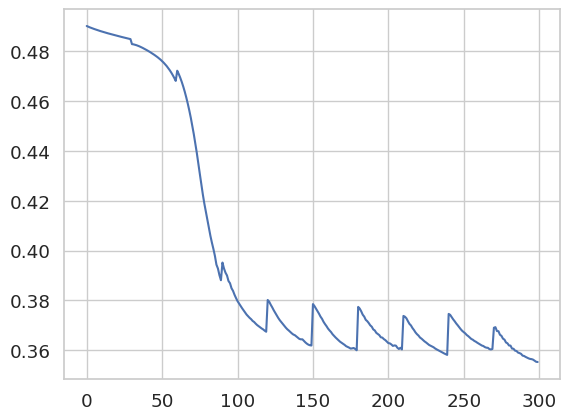

In [35]:
fig, ax = plt.subplots()
ax.plot(get_loss_history(result))

plt.show()

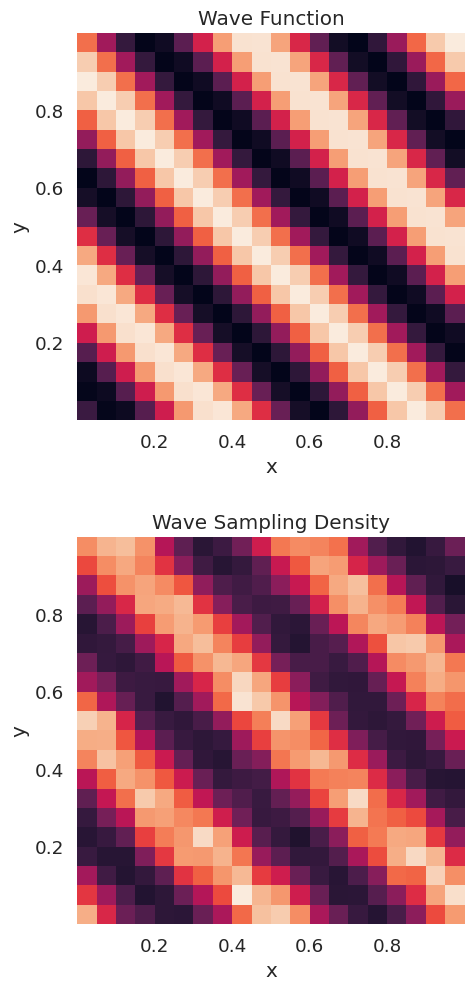

In [37]:
x, _, _ = integrator.sample_refine()
x = x.cpu().numpy()
fig, ax = plt.subplots(2,1)
fig.set_size_inches(5,12)

n = 20
f = SineIntegrand(d=d, f=6, offset=.1)
fmatrix = np.zeros((n,n))
blackmatrix = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        fmatrix[i,n-1-j] = f(torch.tensor([[i/n,j/n]])).numpy()

ticks = np.array([0.2, 0.4, 0.6, 0.8])
hm_xticks = [""]*n
hm_yticks = [""]*n        

sns.heatmap(fmatrix,ax=ax[0],cbar=False, xticklabels=False, yticklabels=False, cmap="rocket")
ax[0].set(xlabel="x", ylabel="y", title="Wave Function", aspect=1)
ax[0].set_xticks(n*ticks)
ax[0].set_xticklabels(ticks)
ax[0].set_yticks(n*ticks)
ax[0].set_yticklabels(reversed(list(ticks)))    

sns.heatmap(blackmatrix,ax=ax[1],cbar=False, cmap="rocket")
sns.histplot(x=x[:100000,0], y=x[:100000,1], ax=ax[1], cmap="rocket", fill=True, bins=n)
plt.xticks(rotation=0)
ax[1].set(xlabel="x", ylabel="y", title="Wave Sampling Density", aspect=1, xlim=[0,1], ylim=[0,1])
ax[1].set_xticks(ticks)
ax[1].set_xticklabels(ticks, rotation=0)
ax[1].set_yticks(ticks)
ax[1].set_yticklabels(ticks, rotation=0)

plt.show()

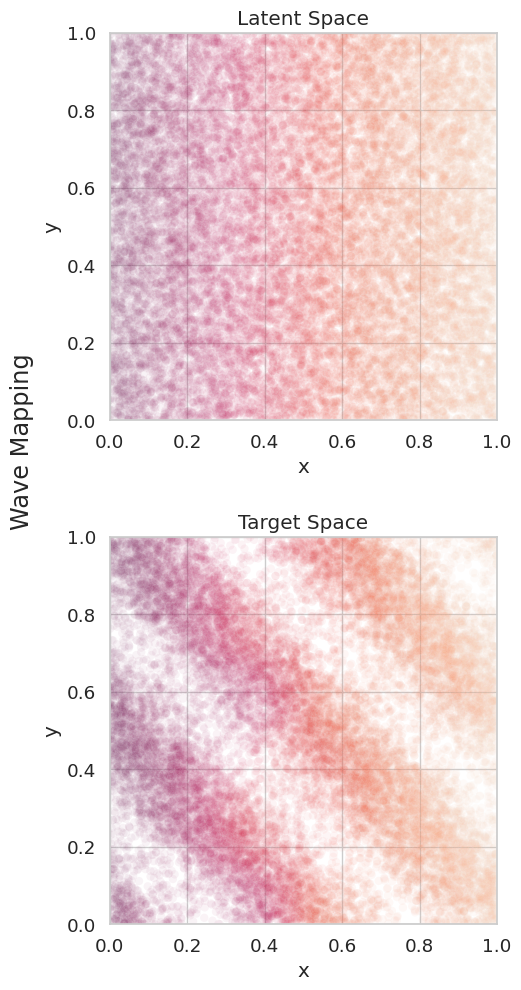

In [47]:
x, _, _ = integrator.sample_survey(n_points=20000)
x = x.cpu()
fig, axs = plt.subplots(2,1)
sns.scatterplot(x=x[:,0], y=x[:,1], hue=x[:,0], legend=False, palette="rocket", hue_norm=(-.5,1.2),alpha=0.05, ax=axs[0])

x = x.to("cuda")
x = torch.cat((x, torch.ones(len(x), device="cuda").unsqueeze(-1)), dim=-1)
y = integrator.model_trainer.flow(x)[:,:2].detach().cpu()
x = x.cpu()

sns.scatterplot(x=y[:,0], y=y[:,1], hue=x[:,0],legend=False, palette="rocket", hue_norm=(-.5,1.2),alpha=0.05, ax=axs[1])
axs[0].set(aspect=1, xlabel="x", ylabel="y", title="Latent Space", xlim=[0,1], ylim=[0,1])
axs[1].set(aspect=1, xlabel="x", ylabel="y", title="Target Space", xlim=[0,1], ylim=[0,1])
fig.set(size_inches=(5,12))
fig.suptitle("Wave Mapping", rotation=90, x=-.05, y=.6)
plt.show()

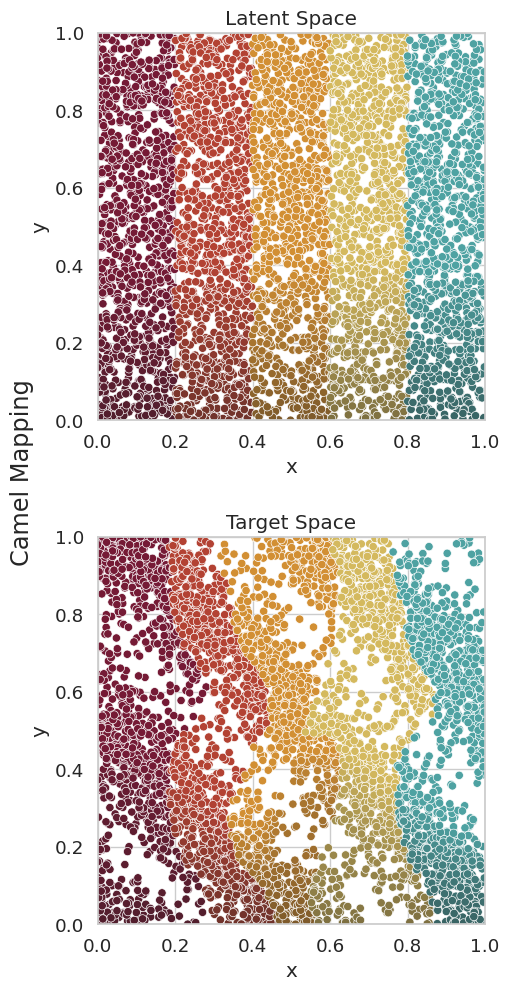

In [39]:
fig, axs = plt.subplots(2,1)
colors = ["#751a35", "#b34233", "#d28f33", "#d4b95e", "#4ea2a2"]
for i in range(5):
    low = i*0.2
    high = low+0.2
    
    x, _, _ = integrator.sample_survey(n_points=5000)
    x = x.cpu()
    x=x[((low<x[:, 0]) &  (x[:,0] < high))]

    sns.scatterplot(x=x[:,0], y=x[:,1], hue=x[:,1], legend=False, palette=sns.dark_palette(colors[i], as_cmap=True), hue_norm=(-.4,.4), ax=axs[0])



    x = x.to("cuda")
    x = torch.cat((x, torch.ones(len(x), device="cuda").unsqueeze(-1)), dim=-1)
    y = integrator.model_trainer.flow(x)[:,:2].detach().cpu()
    x = x.cpu()

    sns.scatterplot(x=y[:,0], y=y[:,1], hue=x[:,1], legend=False, palette=sns.dark_palette(colors[i], as_cmap=True), hue_norm=(-.4,.4),ax=axs[1])

axs[0].set(aspect=1, xlabel="x", ylabel="y", title="Latent Space", xlim=[0,1], ylim=[0,1])
axs[1].set(aspect=1, xlabel="x", ylabel="y", title="Target Space", xlim=[0,1], ylim=[0,1])
fig.set(size_inches=(5,12))
fig.supylabel("Camel Mapping", x=-.05)
plt.show()

In [167]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [199]:
camel_df = pd.DataFrame({
        'VEGAS':[r[0] for r in camel_results['variance_ratio']],
        'Uniform':[r[0] for r in camel_results['flat_variance_ratio']]
})
cl_df = pd.DataFrame({
        'VEGAS':[r[0] for r in cl_results['variance_ratio']],
        'Uniform':[r[0] for r in cl_results['flat_variance_ratio']]
})
sw_df = pd.DataFrame({
        'VEGAS':[r[0] for r in sw_results['variance_ratio']],
        'Uniform':[r[0] for r in sw_results['flat_variance_ratio']]
})
camel_df['Function']='Camel'
cl_df['Function'] = 'Slashed circle (∅)'
sw_df['Function'] = 'Sinusoid'

df = camel_df.append(cl_df, ignore_index=True).append(sw_df, ignore_index=True)

In [200]:
df_melt = pd.melt(df, id_vars=['Function'], value_vars=['Uniform','VEGAS'], value_name='Variance Reduction', var_name='Comparison vs')

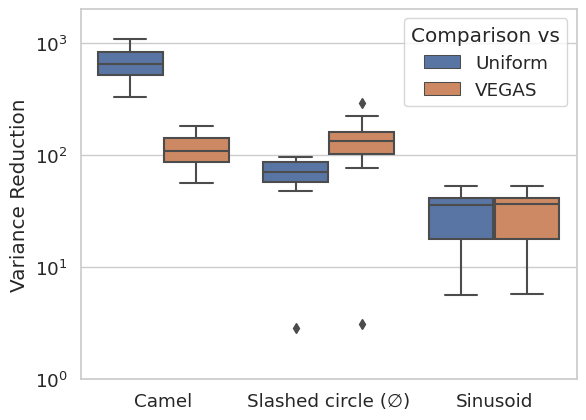

In [201]:
ax = sns.boxplot(data=df_melt, x='Function', y='Variance Reduction', hue='Comparison vs')
ax.set(yscale='log', ylim=[1,2000])
ax.set(xlabel=None)
plt.show()